<a href="https://colab.research.google.com/github/JiseokSeo/-I-studied-/blob/main/%5B%EC%A0%84%EC%B2%98%EB%A6%AC%5D_%EC%9E%90%EB%AA%A8_vs_%EA%B7%B8%EB%83%A5_%EB%8F%8C%EB%A6%AC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade pip
!pip install konlpy
!pip install pororo
!pip install fasttext
!pip install hgtk
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-01-05 09:38:14--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-01-05 09:38:15--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existin

In [8]:
import pandas as pd
import fasttext
from sklearn.model_selection import train_test_split

In [5]:
import hgtk
from tqdm import tqdm
from konlpy.tag import Mecab

def word_to_jamo(token):
    def to_special_token(jamo):
      if not jamo:
        return '-'
      else:
        return jamo
    decomposed_token = ''

    for char in token:
        try:
        # char( 음 절 ) 을 초 성 , 중 성 , 종 성 으 로 분 리
            cho, jung, jong = hgtk.letter.decompose(char)

            # 자 모 가 빈 문 자 일 경 우 특 수 문 자 - 로 대 체
            cho = to_special_token(cho)
            jung = to_special_token(jung)
            jong = to_special_token(jong)
            decomposed_token = decomposed_token + cho + jung + jong

        # 만 약 char( 음 절 ) 이 한 글 이 아 닐 경 우 자 모 를 나 누 지 않 고 추 가
        except Exception as exception:
            if type(exception).__name__ == 'NotHangulException':
                decomposed_token += char

    # 단 어 토 큰 의 자 모 단 위 분 리 결 과 를 추 가
    return decomposed_token


mecab = Mecab()

def tokenize_by_jamo(s):
    return [word_to_jamo(token) for token in mecab.morphs(s)]

def tokenized(data):
  tokenized_data=[]

  for sample in tqdm(data['title'].to_list()):
      tokenzied_sample = tokenize_by_jamo(sample) # 자 소 단 위 토 큰 화
      tokenized_data.append(tokenzied_sample)

  return tokenized_data


def jamo_to_word(jamo_sequence):
    tokenized_jamo = []
    index = 0

# 1. 초 기 입 력
# jamo_sequence = ' ﾤ ￂ ﾱ ﾧ ￌ ﾷ ﾵ ￃ ﾷ '

    while index < len(jamo_sequence):
    # 문 자 가 한 글 ( 정 상 적 인 자 모 ) 이 아 닐 경 우
        if not hgtk.checker.is_hangul(jamo_sequence[index]):
            tokenized_jamo.append(jamo_sequence[index])
            index = index + 1

    # 문 자 가 정 상 적 인 자 모 라 면 초 성 , 중 성 , 종 성 을 하 나 의 토 큰 으 로 간 주 .
        else:
            tokenized_jamo.append(jamo_sequence[index:index + 3])
            index = index + 3

# 2. 자 모 단 위 토 큰 화 완 료
# tokenized_jamo : [' ﾤ ￂ ﾱ ', ' ﾧ ￌ ﾷ ', ' ﾵ ￃ ﾷ ']

        word = ''
        try:
            for jamo in tokenized_jamo:
            # 초 성 , 중 성 , 종 성 의 묶 음 으 로 추 정 되 는 경 우
                if len(jamo) == 3:
                    if jamo[2] == "-":
                    # 종 성 이 존 재 하 지 않 는 경 우
                        word = word + hgtk.letter.compose(jamo[0], jamo[1])
                    else:
                # 종 성 이 존 재 하 는 경 우
                        word = word + hgtk.letter.compose(jamo[0], jamo[1], jamo[2])
                # 한 글 이 아 닌 경 우
                else:
                    word = word + jamo

            # 복 원 중 (hgtk.letter.compose) 에 러 발 생 시 초 기 입 력 리 턴 .
            # 복 원 이 불 가 능 한 경 우 예 시 ) ' ﾤ ! ﾱ ﾧ ￌ ﾷ ﾵ ￃ ﾷ '
        except Exception as exception:
            if type(exception).__name__ == 'NotHangulException':
                return jamo_sequence

        # 3. 단 어 로 복 원 완 료
        # word : ' 남 동 생 '

    return word

In [9]:
df = pd.read_csv('real_finish.csv',
                 encoding='utf-8')

In [10]:
df_train, df_test = train_test_split(df,
                                     test_size=0.1,
                                     stratify=df['category'],
                                     random_state=42)
df_train, df_valid = train_test_split(df_train,
                                      test_size=0.3,
                                      stratify=df_train['category'],
                                      random_state=42)

## 자모 데이터셋 구축 (경모님 노트북 그대로)

In [ ]:
df_train.reset_index(inplace=True)
df_valid.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
train_token = tokenized(df_train.astype(str))
val_token = tokenized(df_valid.astype(str))
test_token = tokenized(df_test.astype(str))

100%|██████████| 20538/20538 [00:03<00:00, 6313.44it/s]


In [ ]:
with open('train_data.txt', 'w') as out:
    for i in tqdm(range(len(train_token)), unit=' line'):
          out.write("__label__" + df_train['category'][i] + "\t" + ' '.join(train_token[i]) + '\n')

with open('val_data.txt', 'w') as out:
    for i in tqdm(range(len(val_token)), unit=' line'):
        out.write("__label__" + df_valid['category'][i] + "\t" + ' '.join(val_token[i]) + '\n')

with open('test_data.txt', 'w') as out:
    for i in tqdm(range(len(test_token)), unit=' line'):
        out.write("__label__" + df_test['category'][i] + "\t" + ' '.join(test_token[i]) + '\n')

100%|██████████| 20538/20538 [00:00<00:00, 127765.95 line/s]


## 실제 생성된 txt파일의 모습

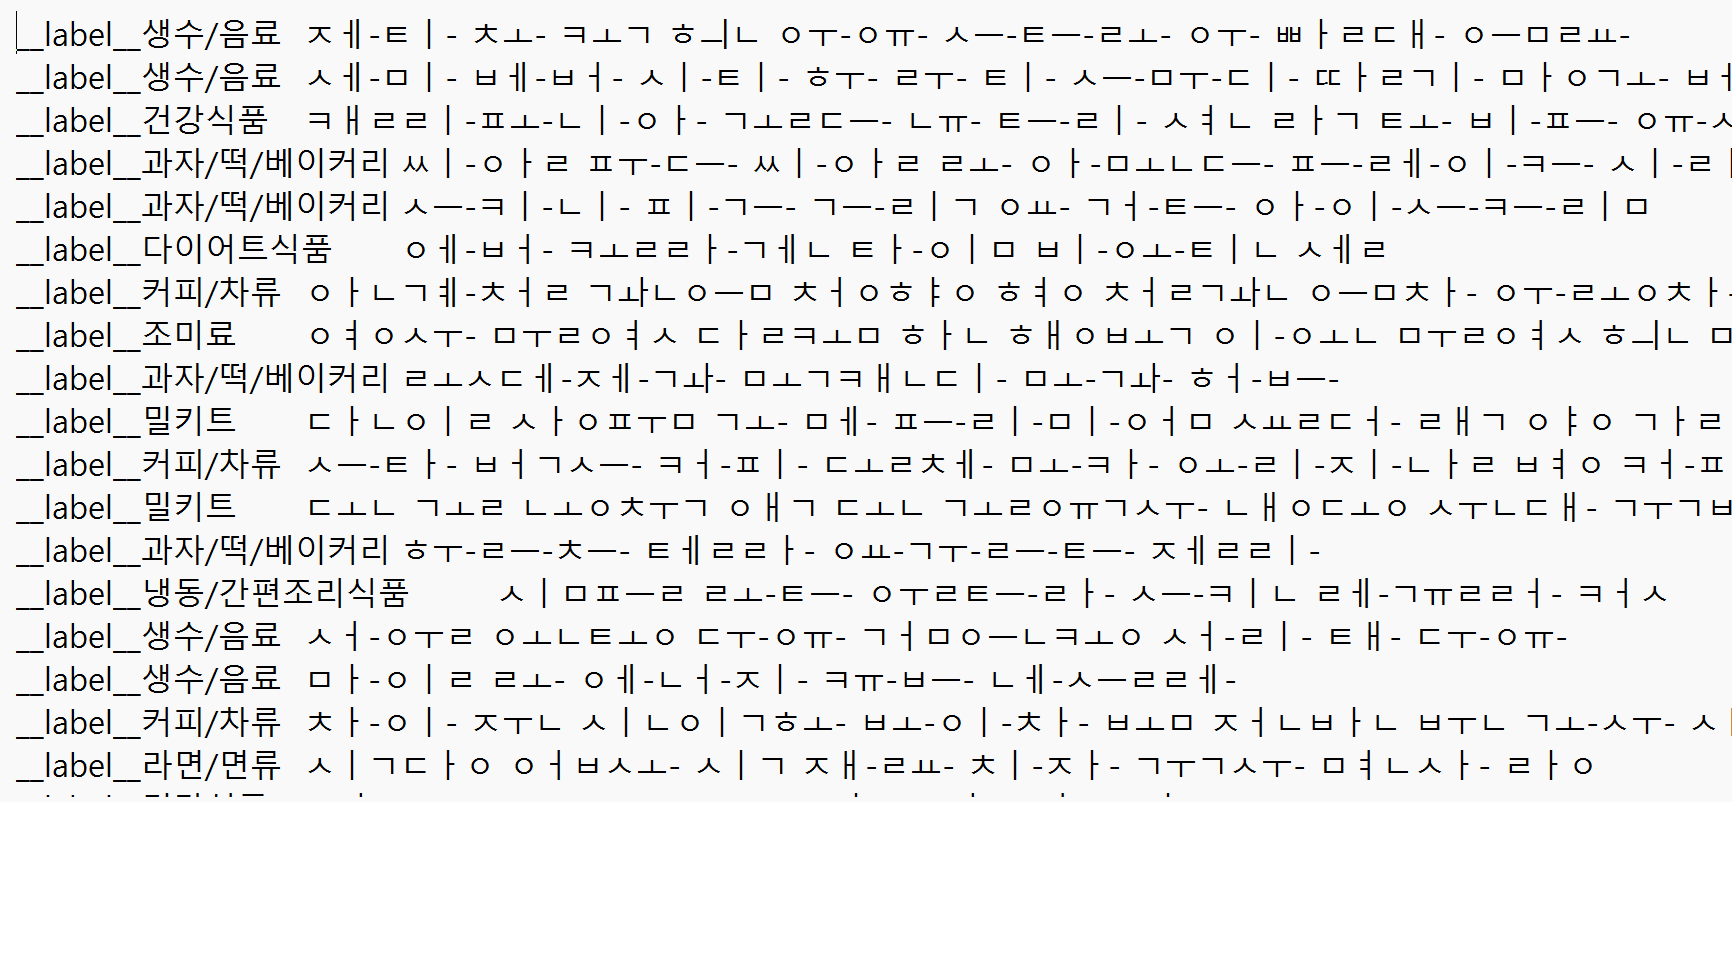

In [11]:
model_jamo = fasttext.train_supervised(input='train_data.txt',
                                       autotuneValidationFile='val_data.txt')

In [12]:
model_jamo.test('test_data.txt')

(20538, 0.9094361671048787, 0.9094361671048787)

In [13]:
model_jamo.predict('ㅂㅏㄴㅏㄴㅏㅇㅜㅇㅠ')

(('__label__커피/차류',), array([0.99235141]))

## 자모로 나누지 않은 데이터셋 준비 

In [31]:
def input_form(df, name):
  df['input_form'] = '__label__' + df['category'] + ' ' + df['title']
  df.reset_index()
  df.to_csv(name, index=False, columns=['input_form'], header=False)

input_form(df_train, 'train')
input_form(df_test, 'test')
input_form(df_valid, 'valid')

In [15]:
normal = fasttext.train_supervised(input='train',
                                   autotuneValidationFile='valid')

In [16]:
normal.test('test')

(20538, 0.9098743791995326, 0.9098743791995326)

In [17]:
normal.predict('바나나우유')

(('__label__생수/음료',), array([1.00000858]))

In [23]:
normal.predict('탑브루어 지석의 스페셜 초코치노')

(('__label__과자/떡/베이커리',), array([0.76578665]))

In [29]:
normal.predict('허리피자')

(('__label__냉동/간편조리식품',), array([0.99999106]))

In [30]:
model_jamo.predict('ㅎㅓㄹㅣㅍㅣㅈㅏ')

(('__label__냉동/간편조리식품',), array([0.66543472]))